In [1]:
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler


import torch 
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

### 데이터

In [2]:
aws_df_raw = pd.read_csv("../data/aws_data_total.csv")

In [3]:
aws_df_rec = pd.read_csv("../data/aws_data_rec.csv")

In [4]:
aws_df_raw

,SpotPrice,SPS,AZ,Region,InstanceType,IF,time
0,0.2691,3,apne1-az1,ap-northeast-1,r3.4xlarge,3.0,2022-03-01 00:08:10+00:00
1,0.7278,1,euw1-az3,eu-west-1,g4dn.8xlarge,2.0,2022-03-01 00:08:10+00:00
2,1.8578,2,use1-az5,us-east-1,r5.24xlarge,1.0,2022-03-01 00:08:10+00:00
3,0.9729,3,use1-az4,us-east-1,g5.8xlarge,1.0,2022-03-01 00:08:10+00:00
4,1.4410,3,use1-az1,us-east-1,r5.16xlarge,1.0,2022-03-01 00:08:10+00:00
...,...,...,...,...,...,...,...
29706394,1.1561,3,euc1-az3,eu-central-1,m5d.12xlarge,2.5,2023-05-10 23:50:00+00:00
29706395,0.4602,3,euw1-az1,eu-west-1,a1.metal,2.5,2023-05-10 23:50:00+00:00
29706396,1.0457,3,usw1-az1,us-west-1,r6g.12xlarge,1.0,2023-05-10 23:50:00+00:00
29706397,1.7306,3,usw2-az1,us-west-2,c5d.12xlarge,3.0,2023-05-10 23:50:00+00:00


In [5]:
aws_df_raw['time'] = pd.to_datetime(aws_df_raw['time'], utc=True)
aws_df_rec['time'] = pd.to_datetime(aws_df_rec['time'], utc=True)

In [6]:
start_date ='2022-08-25'
aws_df_raw = aws_df_raw[aws_df_raw['time'] >= start_date]

# 결과 확인
aws_df_raw

,SpotPrice,SPS,AZ,Region,InstanceType,IF,time
7612824,1.7565,3,apne1-az4,ap-northeast-1,r5dn.metal,0.0,2022-08-25 00:00:00+00:00
7612825,0.3383,3,apne1-az4,ap-northeast-1,r6i.4xlarge,1.0,2022-08-25 00:00:00+00:00
7612826,1.3203,3,cac1-az4,ca-central-1,d3.8xlarge,1.5,2022-08-25 00:00:00+00:00
7612827,1.6226,2,usw2-az4,us-west-2,c6i.24xlarge,2.0,2022-08-25 00:00:00+00:00
7612828,1.7565,2,apne1-az2,ap-northeast-1,r5dn.metal,0.0,2022-08-25 00:00:00+00:00
...,...,...,...,...,...,...,...
29706394,1.1561,3,euc1-az3,eu-central-1,m5d.12xlarge,2.5,2023-05-10 23:50:00+00:00
29706395,0.4602,3,euw1-az1,eu-west-1,a1.metal,2.5,2023-05-10 23:50:00+00:00
29706396,1.0457,3,usw1-az1,us-west-1,r6g.12xlarge,1.0,2023-05-10 23:50:00+00:00
29706397,1.7306,3,usw2-az1,us-west-2,c5d.12xlarge,3.0,2023-05-10 23:50:00+00:00


In [7]:
aws_df = pd.concat([aws_df_raw, aws_df_rec])

### 1. c4.2xlarge / 2. c4.4xlarge / 3. c4.large / 4. c4.xlarge / 5. d2.2xlarge / 6. d2.4xlarge / 7. d2.xlarge
### 8. m4.2xlarge / 9. m4.4xlarge / 10. m4.large /11. m4.xlarge / 12. t2.2xlarge / 13. t2.xlarge

In [8]:
from collections import Counter

aws_df[(aws_df['InstanceType']=='c4.4xlarge') & (aws_df['Region']=='ap-northeast-2')]

,SpotPrice,SPS,AZ,Region,InstanceType,IF,time
7632571,0.2283,3,apne2-az1,ap-northeast-2,c4.4xlarge,1.5,2022-08-25 00:00:00+00:00
7632573,0.2283,3,apne2-az3,ap-northeast-2,c4.4xlarge,1.5,2022-08-25 00:00:00+00:00
10899066,0.0000,3,apne2-az1,ap-northeast-2,c4.4xlarge,1.5,2022-10-12 22:10:00+00:00
10899072,0.0000,3,apne2-az3,ap-northeast-2,c4.4xlarge,1.5,2022-10-12 22:10:00+00:00
10899475,0.2283,3,apne2-az1,ap-northeast-2,c4.4xlarge,1.5,2022-10-12 22:20:00+00:00
...,...,...,...,...,...,...,...
516448,0.2535,3,apne2-az1,ap-northeast-2,c4.4xlarge,2.5,2023-05-18 09:10:00+00:00
528159,0.2485,3,apne2-az3,ap-northeast-2,c4.4xlarge,2.5,2023-05-18 12:50:00+00:00
537493,0.2542,3,apne2-az1,ap-northeast-2,c4.4xlarge,2.5,2023-05-18 16:00:00+00:00
550977,0.2491,3,apne2-az3,ap-northeast-2,c4.4xlarge,2.5,2023-05-18 20:20:00+00:00


### 학습에 사용할 각 InstanceType에 대한 데이터를 분리하여 group_A_dfs list에 저장

In [9]:
from collections import Counter

group_A_dfs = []
instance_list = ['c4.2xlarge', 'c4.4xlarge', 'c4.large', 'c4.xlarge', 'd2.2xlarge', 'd2.4xlarge', 'd2.xlarge', 'm4.2xlarge', 'm4.4xlarge', 'm4.large', 'm4.xlarge', 't2.2xlarge', 't2.xlarge']
az_list = ['apne2-az1', 'apne2-az2', 'apne2-az3']

for instance in instance_list:
    for az in az_list:
        temp_df = aws_df[(aws_df['InstanceType']==instance) & (aws_df['Region']=='ap-northeast-2') & (aws_df['AZ']==az)]
        if len(temp_df) > 0:
            group_A_dfs.append(temp_df)
    

### 전처리 및 feature 생성

In [10]:
max_value = float('-inf')
min_value = float('inf')

for df in group_A_dfs:
    if 'SpotPrice' in df.columns:
        max_value = max(max_value, df['SpotPrice'].max())
        min_value = min(min_value, df['SpotPrice'].min())



print("최대값:", max_value)
print("최소값:", min_value)


최대값: 3.376
최소값: -1.0


In [28]:
from collections import Counter

Counter(group_A_dfs[3]['IF'])

Counter({2.5: 41, 2.0: 20, 1.5: 12, 3.0: 8, 1.0: 1})

In [30]:
SPS_scaler = MinMaxScaler(feature_range=(1, 10))
s_scaler = SPS_scaler.fit(group_A_dfs[1][['SPS']])

IF_scaler = MinMaxScaler(feature_range=(1, 10))
i_scaler = IF_scaler.fit(group_A_dfs[3][['IF']])

In [13]:
df1 = group_A_dfs[2]

In [14]:
df1 = df1.groupby(["InstanceType"])['time'].apply(lambda x:pd. date_range(start=x.min() , end=x.max(), freq="10min")).explode ().reset_index().merge(df1, how='left').ffill()

In [15]:
df1[(df1['IF'] <= 0) | (df1['SPS'] <= 0) | (df1['SpotPrice'] <= 0)]

,InstanceType,time,SpotPrice,SPS,AZ,Region,IF
7045,c4.4xlarge,2022-10-12 22:10:00+00:00,0.0,3.0,apne2-az1,ap-northeast-2,1.5
12859,c4.4xlarge,2022-11-22 07:10:00+00:00,-1.0,3.0,apne2-az1,ap-northeast-2,3.0
13861,c4.4xlarge,2022-11-29 06:10:00+00:00,-1.0,3.0,apne2-az1,ap-northeast-2,3.0
18848,c4.4xlarge,2023-01-02 21:20:00+00:00,-1.0,3.0,apne2-az1,ap-northeast-2,3.0
27886,c4.4xlarge,2023-03-06 15:40:00+00:00,-1.0,3.0,apne2-az1,ap-northeast-2,1.5


In [16]:
df1['SpotPrice'] = df1['SpotPrice'].replace(-1, method='ffill')
df1['SpotPrice'] = df1['SpotPrice'].replace(0, method='ffill')
df1['SPS'] = df1['SPS'].replace(-1, method='ffill')
df1['SPS'] = df1['SPS'].replace(0, method='ffill')
df1['IF'] = df1['IF'].replace(-1, method='ffill')
df1['IF'] = df1['IF'].replace(0, method='ffill')

### input: 요일(One-hot), 월(One-hot), 시간(초로 계산 후 정규화), 안정성 점수(5*(2*sps+if)-2*spotprice)
### output : 예측 시점의 안정성 점수

### **요일 feature**

In [17]:
import datetime

df1['weekday'] = df1['time'].apply(lambda x: datetime.datetime.strftime(x, '%A'))

In [18]:
# One-hot Encoding 
weekday_onehot = pd.get_dummies(df1['weekday'], prefix='weekday')
df1 = pd.concat([df1, weekday_onehot], axis=1)

In [19]:
weekday_columns = ['weekday_Monday', 'weekday_Tuesday', 'weekday_Wednesday',
                   'weekday_Thursday', 'weekday_Friday', 'weekday_Saturday', 'weekday_Sunday']

for column in weekday_columns:
    df1[column] = df1[column].astype('float32')

In [20]:
df1[:5]

,InstanceType,time,SpotPrice,SPS,AZ,Region,IF,weekday,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,c4.4xlarge,2022-08-25 00:00:00+00:00,0.2283,3.0,apne2-az1,ap-northeast-2,1.5,Thursday,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,c4.4xlarge,2022-08-25 00:10:00+00:00,0.2283,3.0,apne2-az1,ap-northeast-2,1.5,Thursday,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,c4.4xlarge,2022-08-25 00:20:00+00:00,0.2283,3.0,apne2-az1,ap-northeast-2,1.5,Thursday,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,c4.4xlarge,2022-08-25 00:30:00+00:00,0.2283,3.0,apne2-az1,ap-northeast-2,1.5,Thursday,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,c4.4xlarge,2022-08-25 00:40:00+00:00,0.2283,3.0,apne2-az1,ap-northeast-2,1.5,Thursday,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### **time to sec feature** 

In [21]:
train_total_seconds = df1['time'].apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)

In [22]:
df1['total_sec'] = train_total_seconds

In [23]:
df1[:5]

,InstanceType,time,SpotPrice,SPS,AZ,Region,IF,weekday,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,total_sec
0,c4.4xlarge,2022-08-25 00:00:00+00:00,0.2283,3.0,apne2-az1,ap-northeast-2,1.5,Thursday,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,c4.4xlarge,2022-08-25 00:10:00+00:00,0.2283,3.0,apne2-az1,ap-northeast-2,1.5,Thursday,0.0,0.0,0.0,0.0,1.0,0.0,0.0,600
2,c4.4xlarge,2022-08-25 00:20:00+00:00,0.2283,3.0,apne2-az1,ap-northeast-2,1.5,Thursday,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1200
3,c4.4xlarge,2022-08-25 00:30:00+00:00,0.2283,3.0,apne2-az1,ap-northeast-2,1.5,Thursday,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1800
4,c4.4xlarge,2022-08-25 00:40:00+00:00,0.2283,3.0,apne2-az1,ap-northeast-2,1.5,Thursday,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2400


### **월 feature**

In [24]:
# 월에 대한 One-hot encoding 구하기
months = pd.get_dummies(df1['time'].dt.month, prefix='month')

df1 = pd.concat([df1, months], axis=1)

In [25]:
for i in range(1, 13):
    col_name = f"month_{i}"
    if col_name not in df1.columns:
        df1[col_name] = False 
        
    if df1[col_name].dtype == bool:
        df1[col_name] = df1[col_name].astype(np.float32)


In [26]:
df1

,InstanceType,time,SpotPrice,SPS,AZ,Region,IF,weekday,weekday_Friday,weekday_Monday,...,month_3,month_4,month_5,month_8,month_9,month_10,month_11,month_12,month_6,month_7
0,c4.4xlarge,2022-08-25 00:00:00+00:00,0.2283,3.0,apne2-az1,ap-northeast-2,1.5,Thursday,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,c4.4xlarge,2022-08-25 00:10:00+00:00,0.2283,3.0,apne2-az1,ap-northeast-2,1.5,Thursday,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,c4.4xlarge,2022-08-25 00:20:00+00:00,0.2283,3.0,apne2-az1,ap-northeast-2,1.5,Thursday,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,c4.4xlarge,2022-08-25 00:30:00+00:00,0.2283,3.0,apne2-az1,ap-northeast-2,1.5,Thursday,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,c4.4xlarge,2022-08-25 00:40:00+00:00,0.2283,3.0,apne2-az1,ap-northeast-2,1.5,Thursday,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38441,c4.4xlarge,2023-05-18 22:50:00+00:00,0.2542,3.0,apne2-az1,ap-northeast-2,2.5,Thursday,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38442,c4.4xlarge,2023-05-18 23:00:00+00:00,0.2542,3.0,apne2-az1,ap-northeast-2,2.5,Thursday,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38443,c4.4xlarge,2023-05-18 23:10:00+00:00,0.2542,3.0,apne2-az1,ap-northeast-2,2.5,Thursday,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38444,c4.4xlarge,2023-05-18 23:20:00+00:00,0.2542,3.0,apne2-az1,ap-northeast-2,2.5,Thursday,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 안정성 점수 feature

In [31]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler


SPS_norm = s_scaler.transform(df1[['SPS']])

IF_norm = i_scaler.transform(df1[['IF']])

spot = df1['SpotPrice'].to_numpy().reshape(-1, 1)

In [32]:
# 안정성 점수 계산
df1['Stability_score'] = 5*(2*SPS_norm + IF_norm) - 2*spot

In [33]:
df1[:5]

,InstanceType,time,SpotPrice,SPS,AZ,Region,IF,weekday,weekday_Friday,weekday_Monday,...,month_4,month_5,month_8,month_9,month_10,month_11,month_12,month_6,month_7,Stability_score
0,c4.4xlarge,2022-08-25 00:00:00+00:00,0.2283,3.0,apne2-az1,ap-northeast-2,1.5,Thursday,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,115.7934
1,c4.4xlarge,2022-08-25 00:10:00+00:00,0.2283,3.0,apne2-az1,ap-northeast-2,1.5,Thursday,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,115.7934
2,c4.4xlarge,2022-08-25 00:20:00+00:00,0.2283,3.0,apne2-az1,ap-northeast-2,1.5,Thursday,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,115.7934
3,c4.4xlarge,2022-08-25 00:30:00+00:00,0.2283,3.0,apne2-az1,ap-northeast-2,1.5,Thursday,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,115.7934
4,c4.4xlarge,2022-08-25 00:40:00+00:00,0.2283,3.0,apne2-az1,ap-northeast-2,1.5,Thursday,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,115.7934


In [34]:
max(df1['Stability_score'])

149.5434

In [35]:
df1['Stability_score_label'] = df1['Stability_score']

In [36]:
input_col = ['weekday_Friday', 'weekday_Monday', 'weekday_Saturday',
       'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday',
       'weekday_Wednesday', 'total_sec', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'month_6', 'month_7', 'Stability_score']

target_col = ['Stability_score_label']

In [37]:
from sklearn.preprocessing import StandardScaler

mm_scaler_x = MinMaxScaler()
mm_scaler_y = MinMaxScaler()
st_scaler = StandardScaler()
rb_scaler = RobustScaler()

x_scaled = mm_scaler_x.fit_transform(df1[input_col])
y_scaled = mm_scaler_y.fit_transform(df1[target_col])


df1[input_col] = x_scaled
df1[target_col] = y_scaled

In [38]:
df1[input_col][:5]

,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,total_sec,month_1,month_2,...,month_4,month_5,month_8,month_9,month_10,month_11,month_12,month_6,month_7,Stability_score
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666682
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.006993,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666682
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.013986,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666682
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.020979,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666682
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.027972,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666682


In [39]:
split_date = '2023-04-28T07:00:00'


train_df = df1[df1['time'] < split_date]
test_df = df1[df1['time'] >= split_date]

In [40]:
test_df

,InstanceType,time,SpotPrice,SPS,AZ,Region,IF,weekday,weekday_Friday,weekday_Monday,...,month_5,month_8,month_9,month_10,month_11,month_12,month_6,month_7,Stability_score,Stability_score_label
35466,c4.4xlarge,2023-04-28 07:00:00+00:00,0.2283,3.0,apne2-az1,ap-northeast-2,2.5,Friday,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.888894,0.888894
35467,c4.4xlarge,2023-04-28 07:10:00+00:00,0.2283,3.0,apne2-az1,ap-northeast-2,2.5,Friday,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.888894,0.888894
35468,c4.4xlarge,2023-04-28 07:20:00+00:00,0.2283,3.0,apne2-az1,ap-northeast-2,2.5,Friday,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.888894,0.888894
35469,c4.4xlarge,2023-04-28 07:30:00+00:00,0.2283,3.0,apne2-az1,ap-northeast-2,2.5,Friday,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.888894,0.888894
35470,c4.4xlarge,2023-04-28 07:40:00+00:00,0.2283,3.0,apne2-az1,ap-northeast-2,2.5,Friday,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.888894,0.888894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38441,c4.4xlarge,2023-05-18 22:50:00+00:00,0.2542,3.0,apne2-az1,ap-northeast-2,2.5,Thursday,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.888382,0.888382
38442,c4.4xlarge,2023-05-18 23:00:00+00:00,0.2542,3.0,apne2-az1,ap-northeast-2,2.5,Thursday,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.888382,0.888382
38443,c4.4xlarge,2023-05-18 23:10:00+00:00,0.2542,3.0,apne2-az1,ap-northeast-2,2.5,Thursday,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.888382,0.888382
38444,c4.4xlarge,2023-05-18 23:20:00+00:00,0.2542,3.0,apne2-az1,ap-northeast-2,2.5,Thursday,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.888382,0.888382


In [745]:
def make_dataset(data, label, window_size= 6):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [746]:
train_X = train_df[input_col]
train_y = train_df[target_col]

In [747]:
X_train, y_train = make_dataset(train_X, train_y)

In [748]:
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)

In [749]:
print(X_train.shape, y_train.shape)

torch.Size([35460, 6, 21]) torch.Size([35460, 1])


In [750]:
num_epochs = 230
batch_size = 128

learning_rate = 0.001 

input_size = 21 #number of features
hidden_size = 100 #number of features in hidden state
num_layers = 3 # stacked lstm layers

output_size = 1 # output classes 

In [751]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


In [752]:
train_dataset = TensorDataset(X_train, y_train)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

In [753]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

In [754]:
device

device(type='cuda')

In [755]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [756]:
import time

loss_values = [] # loss 값을 저장할 리스트

for epoch in range(num_epochs):
    start_time = time.time()  # 시작 시간 저장
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)

        outputs = model(inputs)
        optimizer.zero_grad()

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    
    epoch_loss = running_loss / len(train_loader)
    loss_values.append(epoch_loss) # epoch_loss 값 리스트에 추가
    end_time = time.time()  # 종료 시간 저장
    epoch_time = end_time - start_time  # 한 에폭에 걸린 시간
    
    print('Epoch [{}/{}], Loss: {:.4f}, Time: {:.2f}s'.format(epoch+1, num_epochs, epoch_loss, epoch_time))


Epoch [1/230], Loss: 0.0531, Time: 0.98s
Epoch [2/230], Loss: 0.0530, Time: 0.88s
Epoch [3/230], Loss: 0.0471, Time: 0.88s
Epoch [4/230], Loss: 0.0521, Time: 0.92s
Epoch [5/230], Loss: 0.0429, Time: 1.25s
Epoch [6/230], Loss: 0.0319, Time: 1.22s
Epoch [7/230], Loss: 0.0321, Time: 1.18s
Epoch [8/230], Loss: 0.0152, Time: 0.86s
Epoch [9/230], Loss: 0.0097, Time: 0.89s
Epoch [10/230], Loss: 0.0039, Time: 0.89s
Epoch [11/230], Loss: 0.0027, Time: 0.89s
Epoch [12/230], Loss: 0.0025, Time: 0.88s
Epoch [13/230], Loss: 0.0025, Time: 0.88s
Epoch [14/230], Loss: 0.0024, Time: 0.88s
Epoch [15/230], Loss: 0.0025, Time: 0.86s
Epoch [16/230], Loss: 0.0026, Time: 0.87s
Epoch [17/230], Loss: 0.0027, Time: 0.87s
Epoch [18/230], Loss: 0.0025, Time: 0.87s
Epoch [19/230], Loss: 0.0023, Time: 1.14s
Epoch [20/230], Loss: 0.0020, Time: 1.22s
Epoch [21/230], Loss: 0.0018, Time: 1.22s
Epoch [22/230], Loss: 0.0015, Time: 0.94s
Epoch [23/230], Loss: 0.0008, Time: 0.88s
Epoch [24/230], Loss: 0.0010, Time: 0.88s
E

In [757]:
test_X = test_df[['weekday_Friday', 'weekday_Monday', 'weekday_Saturday',
       'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday',
       'weekday_Wednesday', 'total_sec', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'month_6', 'month_7', 'Stability_score']]
test_y = test_df[target_col]

In [758]:
def make_dataset_2(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [759]:
X_test, y_test = make_dataset_2(test_X, test_y, window_size=6)

X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

In [41]:
test_df[:5]

,InstanceType,time,SpotPrice,SPS,AZ,Region,IF,weekday,weekday_Friday,weekday_Monday,...,month_5,month_8,month_9,month_10,month_11,month_12,month_6,month_7,Stability_score,Stability_score_label
35466,c4.4xlarge,2023-04-28 07:00:00+00:00,0.2283,3.0,apne2-az1,ap-northeast-2,2.5,Friday,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.888894,0.888894
35467,c4.4xlarge,2023-04-28 07:10:00+00:00,0.2283,3.0,apne2-az1,ap-northeast-2,2.5,Friday,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.888894,0.888894
35468,c4.4xlarge,2023-04-28 07:20:00+00:00,0.2283,3.0,apne2-az1,ap-northeast-2,2.5,Friday,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.888894,0.888894
35469,c4.4xlarge,2023-04-28 07:30:00+00:00,0.2283,3.0,apne2-az1,ap-northeast-2,2.5,Friday,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.888894,0.888894
35470,c4.4xlarge,2023-04-28 07:40:00+00:00,0.2283,3.0,apne2-az1,ap-northeast-2,2.5,Friday,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.888894,0.888894


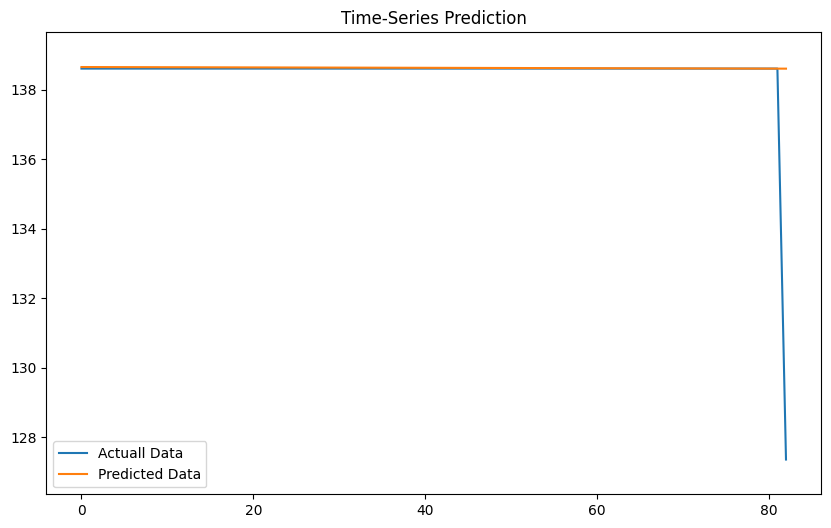

In [761]:
import matplotlib.pyplot as plt

model.eval()

predict = model(X_test.to(device))
pred = predict.data.detach().cpu().numpy()
target = y_test.data.numpy()

pred = mm_scaler_y.inverse_transform(pred)
target = mm_scaler_y.inverse_transform(target)

plt.figure(figsize=(10,6)) #plotting

plt.plot(target, label='Actuall Data') #actual plot 
plt.plot(pred, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()

plt.ylim(bottom=min(min(target), min(pred))-1, top=max(max(target), max(pred))+1)

plt.show() 

In [762]:
mape = np.mean(np.abs((target - pred) / target)) * 100

print('MAPE:', mape)

MAPE: 0.1223707920871675


In [42]:
test_df[:1]

,InstanceType,time,SpotPrice,SPS,AZ,Region,IF,weekday,weekday_Friday,weekday_Monday,...,month_5,month_8,month_9,month_10,month_11,month_12,month_6,month_7,Stability_score,Stability_score_label
35466,c4.4xlarge,2023-04-28 07:00:00+00:00,0.2283,3.0,apne2-az1,ap-northeast-2,2.5,Friday,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.888894,0.888894


In [765]:
import pickle

with open("./t2_xlarge_1_target_scaler.pickle", 'wb') as f:
    pickle.dump(mm_scaler_y, f)

In [766]:
torch.save(model.state_dict(), './t2_xlarge_az1_state.pt')